<a href="https://colab.research.google.com/github/JuanCruzFM/Procesamiento-Digital-de-Imagenes/blob/master/Trabajo_Final_Juan_Cruz_Fernandez_Marquez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Espectro Multifractal de Imagenes Satelitales de la Ría de  Bahía Blanca**



 El objetivo del trabajo propuesto es determinar el espectro multifractal de imagenes satelitales de la Ría de Bahía Blanca para su caracterización. En las siguientes lineas se comenta el método y implementación del trabajo.






In [26]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy.sparse import coo_matrix
import scipy.sparse.linalg as linsolve

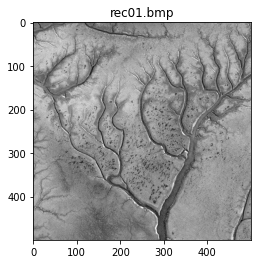

In [27]:
#importo la imagen y la convierto a un arreglo en escala gris
imagen='rec01.bmp'
Imagen=Image.open(imagen).convert('L')
ArregloImagen=np.array(Imagen).astype(int)

plt.imshow(ArregloImagen,cmap='gray')
plt.title(imagen)
plt.show()

En primer lugar, para describir el comportamiento local de la imagen se
calcula una medida $\mu$ en cada punto y luego se obtiene el exponente de Hölder $\alpha$. Si se considera una celda $E_{i}$ de lado $\delta$ centrada en un punto $(x,y)$ se define $\alpha_{i}$ como
\begin{equation}
\alpha_{i}= \frac{ln \left( \mu(E_{i}) \right)}{ln (\delta)} , 
\end{equation}
el exponente de Hölder se obtiene tomando el límite de $\delta$ tenidendo a cero
\begin{equation}
\alpha=\lim_{\delta \to 0} \alpha_{i} .
\end{equation}
A fines prácticos la obtencion numérica del exponente de Hölder $\alpha$ en un punto $(x,y)$  se realiza a través del ajuste lineal entre $ln\ \mu(E_{i})$ y  $ln\ \delta$. La imagen obtenida por medio de asignar a la lumninancia en un punto (pixel) el respectivo exponente de Hölder se denomina $\alpha$-imagen.

Existen diferentes tipos de medidas $\mu$ que pueden utilizarce, cada una produce diferentes exponentes de Hölder. En la siguiente linea de codigo se utiliza la medida Suma. Dado un punto de la imagen $(x,y)$ la medida Suma se obtiene sumando las luminancias de la celda asociada con $(x,y)$. 


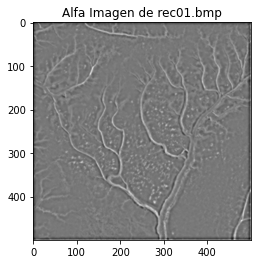

In [28]:
def Alfa_Imagen_Suma(ArregloImagen,C):
  ancho,alto=ArregloImagen.shape
  N=C #cantidad de celdas utilizadas para calcular la medida en un punto (x,y),el lado de la celda es 2*n+1
  #defino arreglos que voy a utilizar para obtener la alfa-imagen
  medida=np.zeros(N*alto)
  AlfaImagen=np.zeros((ancho,alto))
  auxx=np.zeros(N) 
  for i in range(N):
      auxx[i]=2*(i+1)+1
  denominador=np.log(auxx)
  b = np.vstack((denominador,np.ones((1,N)))).T
  AA=coo_matrix(np.kron(np.identity(ancho), b))
  #obtengo la alfa-imagen a traves de resolver un sistema de ecuaciones lineales a traves de cuadrados minimos
  for x in range(ancho):
      for y in range(alto):
          for CantCeldas in range(N):
            
              medida[CantCeldas+y*N]=np.sum(ArregloImagen[max(x-(CantCeldas+1),0):min(x+(CantCeldas+2),ancho-1),max(y-(CantCeldas+1),0):min(y+(CantCeldas+2),alto-1)]) + 0.01

      bb=np.log(medida)
      z = linsolve.lsqr(AA,bb)[0]
      z = z.reshape(2,alto,order = 'F')
      AlfaImagen[x,:] = z[0]
  return AlfaImagen

AlfaImagen=Alfa_Imagen_Suma(ArregloImagen,8)

plt.imshow(AlfaImagen,'gray')
plt.title('Alfa Imagen de ' +imagen, loc='center')
plt.show()  

Una vez descrito el comportamiento local de la imagen mediante el exponente de Hölder, se describe el comportamiento global. Con tal motivo se define la función $f_{\delta}(\alpha)$ que relaciona la cantidad de celdas $N_{\delta}(\alpha)$ caracterizadas por un $\alpha$ dado y el lado $\delta$ de la celda
\begin{equation}
f_{\delta}(\alpha)=-\frac{ln \ N_{\delta}(\alpha)}{ln \ \delta }.
\end{equation}
Se obtiene la dimensión de Haussdorf de cada conjunto de puntos caracterizado por un dado $\alpha$ al tomar el límte de $\delta$ tendiendo a cero (espectro multifractal)
\begin{equation}
f(\alpha)=\lim_{\delta \to 0} f_{\delta}(\alpha).
\end{equation}

Para calcular la dimensinónn de Haussdorf para un dado $\alpha$ de la imagen se utiliza la Dimensión Box. Para este motivo se discretiza el intervalo de los exponentes de Hölder en  C clases de equivalencia y a cada uno se le computa la Dimensión Box.


In [29]:
def MaxMin(AlfaImagen,w):
  #Maximo y minimo valor de alfa 
  AlfaMax=np.amax(AlfaImagen)
  AlfaMin=np.amin(AlfaImagen)
  #Defino el número de clases de equivalencia
  C=w

  Delta=(AlfaMax-AlfaMin)/C
  #Vector de clases de equivalencias
  VC=np.zeros(C)
  VC = np.arange(AlfaMin,AlfaMax,Delta) 
  #vector auxiliar para generar la alfa imagen
  PC=np.zeros(C+1)
  PC[0:C]=VC
  PC[C]=VC[C-1]+1
  return VC,PC,C
VC,PC,C=MaxMin(AlfaImagen,20)


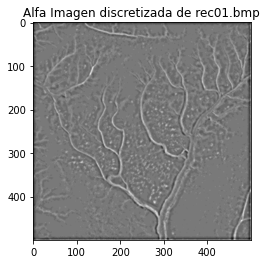

In [30]:
def DAlfa(AlfaImagen,PC,VC,C):
  #obtengo alfa imagen discretizada en C clases de equivalencia
  ancho,alto=AlfaImagen.shape
  AlfaImagenC=np.zeros((ancho,alto))
  for x in range(ancho):
      for y in range(alto):
          for i in range(C):
              if AlfaImagen[x,y]>=PC[i] and AlfaImagen[x,y]<PC[i+1]:
                  AlfaImagenC[x,y]=VC[i] #imagen cuantizada en C clases de equivalencia #imagen cuantizada en C clases de equivalencia
  return AlfaImagenC
AlfaImagenCuant=DAlfa(AlfaImagen,PC,VC,C)
plt.imshow(AlfaImagenCuant,'gray')
plt.title('Alfa Imagen discretizada de '+imagen)
plt.show()  


Una vez discretizada la $\alpha$-imagen en C clases de equivalencia, se lleva a cabo un Box Counting para cada una de las C clases de equivalencia. Para obtener el la dimensión de Haussdorf para un dado esponente de Hölder $\alpha$ se realiza una regresión lineal de $ln \ N_{\delta}(\alpha)$ en función de $ln \ \delta$. Finalmente, al reemplazar en cada punto de la $\alpha$-imagen la luminancia dada por el exponete de Hölder por su respectiva dimensión de Haussdorf se obtiene la $f(\alpha)$-imagen. 

In [31]:
#Defino una funcion que parte una matrix en bloques iguales
def split(Arreglo, nrows, ncols):
    r, h = Arreglo.shape
    return (Arreglo.reshape(h//nrows, nrows, -1, ncols).swapaxes(1, 2).reshape(-1, nrows, ncols))

In [32]:
def f_alfa(AlfaImagenC,VC,C):
  L=np.array([2,4,5,10,20,25,50]) #tamaño de las cajas para hacer el covering de la imagen para impletmentar  box counting (cubren totalmente una imagen de 500x500)

  Nalfa=np.zeros((len(VC),len(L))) # Arreglo N_alfas (cantidad de celdas caracterizadas por un alfa_i)

  f_alfa=np.zeros(C) #Arreglo a utilizar para 


  #obtengo los f alfas (box counting)
  for j in range(C):
      for i in range(len(L)):
          Bloques=split(AlfaImagenC,L[i],L[i])
          r,s,p=Bloques.shape
  
          contador=0
          for CantBloques in range(r):
              if len(np.where(Bloques[CantBloques,:,:]==VC[j])[0])!=0:
                  contador=contador+1
        
          Nalfa[j,i]=contador+0.01
      (f,o)=-np.polyfit(np.log(L),np.log(Nalfa[j,:]),1)
      f_alfa[j]=f
  return f_alfa
fAlfa=f_alfa(AlfaImagenCuant,VC,C) 

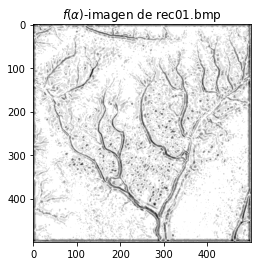

In [33]:
def f_Imagen(AlfaImagenC,C,VC,f_alfa):
  ancho,alto=AlfaImagenC.shape
  #genero la f alfa imagen
  f_imagen=np.zeros((ancho,alto))
  for x in range(ancho):
      for y in range(alto):
          for i in range(C):
              if AlfaImagenC[x,y]==VC[i]:
                  f_imagen[x,y]=f_alfa[i]
  return f_imagen
f_imagen=f_Imagen(AlfaImagenCuant,C,VC,fAlfa)
            
plt.imshow(f_imagen,'gray')
plt.title(r'$f(\alpha)$-imagen de '+imagen)
plt.show()    


A través de la $f(\alpha)$-imagen se peude segmentar la imagen, por ejemplo utilizado el metodo del valor umbral de Otsu se obtiene la siguiente binarización

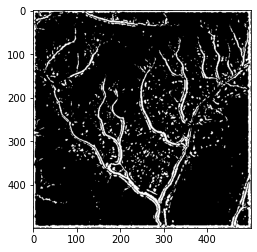

In [34]:
#puedo segmentar la imagen a traves de la f alfa imagen a traves de algun criterio que desee

umbral=threshold_otsu(f_imagen)
binary=f_imagen < umbral #invierto, para que el fondo quede negro

plt.imshow(binary,'gray')
plt.show()    
    

#pinpin=np.ravel(AlfaImagenC)
#plt.hist(pinpin,bins=VC)
#plt.show()

Por último, una de las aplicaciones mas importantes de la multifractalidad en imagenes es la caracterización a través del espectro multifractal.

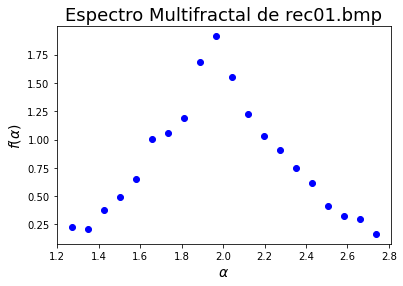

In [35]:
#grafico el espectro multifractal contra los alfa (exponentes de Hölder)
plt.plot(VC,fAlfa,'bo')
plt.ylabel(r'$f(\alpha)$',fontsize=14)
plt.xlabel(r'$ \alpha $',fontsize=14)
plt.title("Espectro Multifractal de "+imagen,fontsize=18) 
plt.show()      


Para otros sectores de la Ría de Bahía Blanca también se calculo el espectro de multifractal

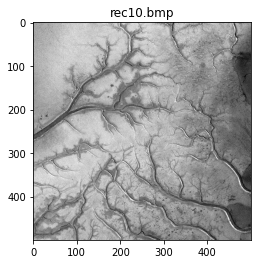

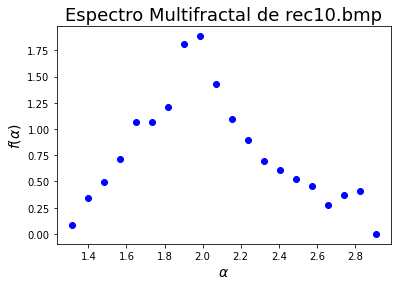

In [36]:
imagen_1='rec10.bmp'
Imagen_1=Image.open(imagen_1).convert('L')
ArregloImagen_1=np.array(Imagen_1).astype(int)

plt.imshow(ArregloImagen_1,cmap='gray')
plt.title(imagen_1)
plt.show()

AlfaImagen_1=Alfa_Imagen_Suma(ArregloImagen_1,8)

VC_1,PC_1,C_1=MaxMin(AlfaImagen_1,20)

AlfaImagenCuant_1=DAlfa(AlfaImagen_1,PC_1,VC_1,C_1)

falfa_1=f_alfa(AlfaImagenCuant_1,VC_1,C_1)

plt.plot(VC_1,falfa_1,'bo')
plt.ylabel(r'$f(\alpha)$',fontsize=14)
plt.xlabel(r'$ \alpha $',fontsize=14)
plt.title("Espectro Multifractal de "+imagen_1,fontsize=18) 
plt.show()   

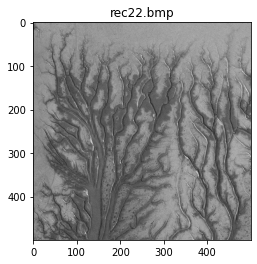

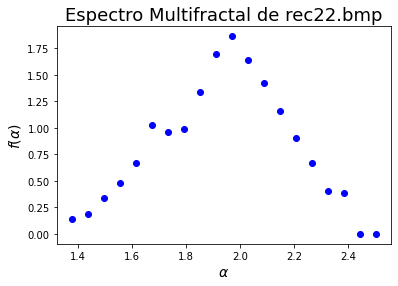

In [37]:
imagen_2='rec22.bmp'
Imagen_2=Image.open(imagen_2).convert('L')
ArregloImagen_2=np.array(Imagen_2).astype(int)

plt.imshow(ArregloImagen_2,cmap='gray')
plt.title(imagen_2)
plt.show()

AlfaImagen_2=Alfa_Imagen_Suma(ArregloImagen_2,8)

VC_2,PC_2,C_2=MaxMin(AlfaImagen_2,20)

AlfaImagenCuant_2=DAlfa(AlfaImagen_2,PC_2,VC_2,C_2)

falfa_2=f_alfa(AlfaImagenCuant_2,VC_2,C_2)

plt.plot(VC_2,falfa_2,'bo')
plt.ylabel(r'$f(\alpha)$',fontsize=14)
plt.xlabel(r'$ \alpha $',fontsize=14)
plt.title("Espectro Multifractal de "+imagen_2,fontsize=18) 
plt.show()

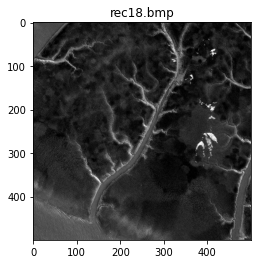

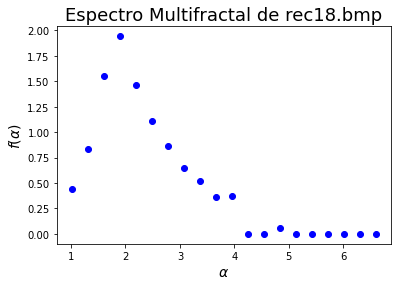

In [38]:
imagen_3='rec18.bmp'
Imagen_3=Image.open(imagen_3).convert('L')
ArregloImagen_3=np.array(Imagen_3).astype(int)

plt.imshow(ArregloImagen_3,cmap='gray')
plt.title(imagen_3)
plt.show()

AlfaImagen_3=Alfa_Imagen_Suma(ArregloImagen_3,8)

VC_3,PC_3,C_3=MaxMin(AlfaImagen_3,20)

AlfaImagenCuant_3=DAlfa(AlfaImagen_3,PC_3,VC_3,C_3)

falfa_3=f_alfa(AlfaImagenCuant_3,VC_3,C_3)

plt.plot(VC_3,falfa_3,'bo')
plt.ylabel(r'$f(\alpha)$',fontsize=14)
plt.xlabel(r'$ \alpha $',fontsize=14)
plt.title("Espectro Multifractal de "+imagen_3,fontsize=18) 
plt.show()

Por otro lado, diferentes medidas $\mu$ dan lugar a diferentes espectros multifractales ya que se modifica el exponente de Hölder. 

Se pueden calcular las $\alpha$-imagenes correspondientes a la medida Máximo y Diferencia Absoluta con el siguientes codigos

In [39]:
#calcula la alfa-imagen utilizando como medida de un punto (x,y) el maximo correspondiente a su entorno
def Alfa_Imagen_Max(ArregloImagen,C):
  ancho,alto=ArregloImagen.shape
  N=C #cantidad de celdas utilizadas para calcular la medida en un punto (x,y),el lado de la celda es 2*n+1
  #defino arreglos que voy a utilizar para obtener la alfa-imagen
  medida=np.zeros(N*alto)
  AlfaImagen=np.zeros((ancho,alto))
  auxx=np.zeros(N) 
  for i in range(N):
      auxx[i]=2*(i+1)+1
  denominador=np.log(auxx)
  b = np.vstack((denominador,np.ones((1,N)))).T
  AA=coo_matrix(np.kron(np.identity(ancho), b))
  #obtengo la alfa-imagen a traves de resolver un sistema de ecuaciones lineales a traves de cuadrados minimos
  for x in range(ancho):
      for y in range(alto):
          for CantCeldas in range(N):
            
              medida[CantCeldas+y*N]=np.amax(ArregloImagen[max(x-(CantCeldas+1),0):min(x+(CantCeldas+2),ancho-1),max(y-(CantCeldas+1),0):min(y+(CantCeldas+2),alto-1)]) + 0.01

      bb=np.log(medida)
      z = linsolve.lsqr(AA,bb)[0]
      z = z.reshape(2,alto,order = 'F')
      AlfaImagen[x,:] = z[0]
  return AlfaImagen

In [40]:
#calcula la alfa-imagen utilizando como medida de un punto (x,y) el maximo correspondiente a su entorno
def Alfa_Imagen_Max(ArregloImagen,C):
  ancho,alto=ArregloImagen.shape
  N=C #cantidad de celdas utilizadas para calcular la medida en un punto (x,y),el lado de la celda es 2*n+1
  #defino arreglos que voy a utilizar para obtener la alfa-imagen
  medida=np.zeros(N*alto)
  AlfaImagen=np.zeros((ancho,alto))
  auxx=np.zeros(N) 
  for i in range(N):
      auxx[i]=2*(i+1)+1
  denominador=np.log(auxx)
  b = np.vstack((denominador,np.ones((1,N)))).T
  AA=coo_matrix(np.kron(np.identity(ancho), b))
  #obtengo la alfa-imagen a traves de resolver un sistema de ecuaciones lineales a traves de cuadrados minimos
  for x in range(ancho):
      for y in range(alto):
          for CantCeldas in range(N):
            
              medida[CantCeldas+y*N]=np.amax(ArregloImagen[max(x-(CantCeldas+1),0):min(x+(CantCeldas+2),ancho-1),max(y-(CantCeldas+1),0):min(y+(CantCeldas+2),alto-1)]) + 0.01

      bb=np.log(medida)
      z = linsolve.lsqr(AA,bb)[0]
      z = z.reshape(2,alto,order = 'F')
      AlfaImagen[x,:] = z[0]
  return AlfaImagen

In [41]:
#calcula la alfa-imagen utilizando como medida de un punto (x,y) la diferencia maxima entre dos puntos de su entorno(la diferencia maxima corresponde la resta del maximo y el minimo ya que son numeros positivos)
def Alfa_Imagen_DifAbs(ArregloImagen,C):
  ancho,alto=ArregloImagen.shape
  N=C #cantidad de celdas utilizadas para calcular la medida en un punto (x,y),el lado de la celda es 2*n+1
  #defino arreglos que voy a utilizar para obtener la alfa-imagen
  medida=np.zeros(N*alto)
  AlfaImagen=np.zeros((ancho,alto))
  auxx=np.zeros(N) 
  for i in range(N):
      auxx[i]=2*(i+1)+1
  denominador=np.log(auxx)
  b = np.vstack((denominador,np.ones((1,N)))).T
  AA=coo_matrix(np.kron(np.identity(ancho), b))
  #obtengo la alfa-imagen a traves de resolver un sistema de ecuaciones lineales a traves de cuadrados minimos
  for x in range(ancho):
      for y in range(alto):
          for CantCeldas in range(N):
            
              medida[CantCeldas+y*N]=np.amax(ArregloImagen[max(x-(CantCeldas+1),0):min(x+(CantCeldas+2),ancho-1),max(y-(CantCeldas+1),0):min(y+(CantCeldas+2),alto-1)]) - np.amin(ArregloImagen[max(x-(CantCeldas+1),0):min(x+(CantCeldas+2),ancho-1),max(y-(CantCeldas+1),0):min(y+(CantCeldas+2),alto-1)]) + 0.01

      bb=np.log(medida)
      z = linsolve.lsqr(AA,bb)[0]
      z = z.reshape(2,alto,order = 'F')
      AlfaImagen[x,:] = z[0]
  return AlfaImagen

Entonces se pueden calcular los espectros multifractales correspondientes a las medidas Máximo y Diferencia Absoluta.

Para la medida Máximo los espectros multifracatales son los siguientes:

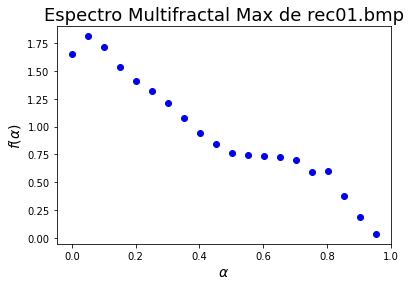

In [42]:
#espectro multifractal Max rec01
AlfaImagen_max=Alfa_Imagen_Max(ArregloImagen,8)

VC_max,PC_max,C_max=MaxMin(AlfaImagen_max,20)

AlfaImagenCuant_max=DAlfa(AlfaImagen_max,PC_max,VC_max,C_max)

falfa_max=f_alfa(AlfaImagenCuant_max,VC_max,C_max)

plt.plot(VC_max,falfa_max,'bo')
plt.ylabel(r'$f(\alpha)$',fontsize=14)
plt.xlabel(r'$ \alpha $',fontsize=14)
plt.title("Espectro Multifractal Max de "+imagen,fontsize=18) 
plt.show()  

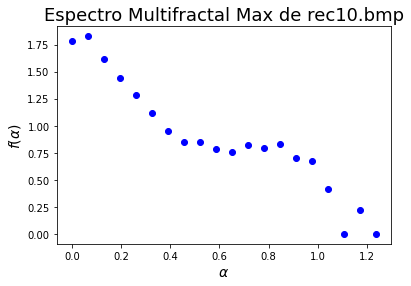

In [43]:
#espectro multifractal Max rec10
AlfaImagen_max_1=Alfa_Imagen_Max(ArregloImagen_1,8)

VC_max_1,PC_max_1,C_max_1=MaxMin(AlfaImagen_max_1,20)

AlfaImagenCuant_max_1=DAlfa(AlfaImagen_max_1,PC_max_1,VC_max_1,C_max_1)

falfa_max_1=f_alfa(AlfaImagenCuant_max_1,VC_max_1,C_max_1)

plt.plot(VC_max_1,falfa_max_1,'bo')
plt.ylabel(r'$f(\alpha)$',fontsize=14)
plt.xlabel(r'$ \alpha $',fontsize=14)
plt.title("Espectro Multifractal Max de "+imagen_1,fontsize=18) 
plt.show()  

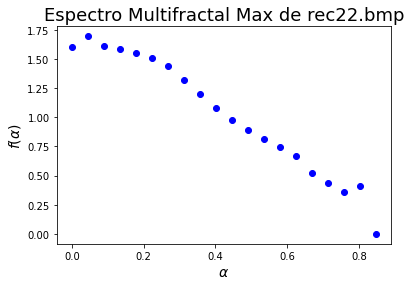

In [44]:
#espectro multifractal Max rec22
AlfaImagen_max_2=Alfa_Imagen_Max(ArregloImagen_2,8)

VC_max_2,PC_max_2,C_max_2=MaxMin(AlfaImagen_max_2,20)

AlfaImagenCuant_max_2=DAlfa(AlfaImagen_max_2,PC_max_2,VC_max_2,C_max_2)

falfa_max_2=f_alfa(AlfaImagenCuant_max_2,VC_max_2,C_max_2)

plt.plot(VC_max_2,falfa_max_2,'bo')
plt.ylabel(r'$f(\alpha)$',fontsize=14)
plt.xlabel(r'$ \alpha $',fontsize=14)
plt.title("Espectro Multifractal Max de "+imagen_2,fontsize=18) 
plt.show() 

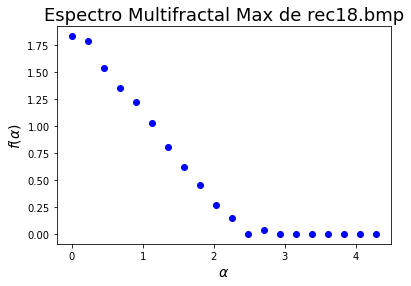

In [45]:
#espectro multifractal Max rec18
AlfaImagen_max_3=Alfa_Imagen_Max(ArregloImagen_3,8)

VC_max_3,PC_max_3,C_max_3=MaxMin(AlfaImagen_max_3,20)

AlfaImagenCuant_max_3=DAlfa(AlfaImagen_max_3,PC_max_3,VC_max_3,C_max_3)

falfa_max_3=f_alfa(AlfaImagenCuant_max_3,VC_max_3,C_max_3)

plt.plot(VC_max_3,falfa_max_3,'bo')
plt.ylabel(r'$f(\alpha)$',fontsize=14)
plt.xlabel(r'$ \alpha $',fontsize=14)
plt.title("Espectro Multifractal Max de "+imagen_3,fontsize=18) 
plt.show() 

Finalmente, los espectros multifractales para la medida Diferencia Absoluta se encuentran a continuación:

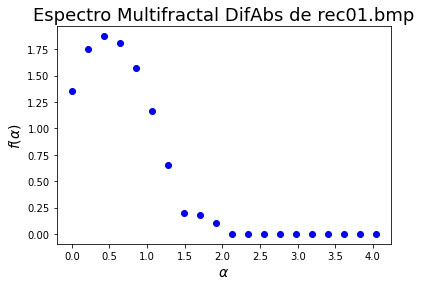

In [46]:
#espectro multifractal DifAbs rec01
AlfaImagen_dif=Alfa_Imagen_DifAbs(ArregloImagen,8)

VC_dif,PC_dif,C_dif=MaxMin(AlfaImagen_dif,20)

AlfaImagenCuant_dif=DAlfa(AlfaImagen_dif,PC_dif,VC_dif,C_dif)

falfa_dif=f_alfa(AlfaImagenCuant_dif,VC_dif,C_dif)

plt.plot(VC_dif,falfa_dif,'bo')
plt.ylabel(r'$f(\alpha)$',fontsize=14)
plt.xlabel(r'$ \alpha $',fontsize=14)
plt.title("Espectro Multifractal DifAbs de "+imagen,fontsize=18) 
plt.show()  

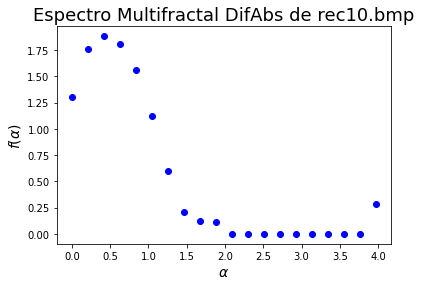

In [47]:
#espectro multifractal DifAbs rec10
AlfaImagen_dif_1=Alfa_Imagen_DifAbs(ArregloImagen_1,8)

VC_dif_1,PC_dif_1,C_dif_1=MaxMin(AlfaImagen_dif_1,20)

AlfaImagenCuant_dif_1=DAlfa(AlfaImagen_dif_1,PC_dif_1,VC_dif_1,C_dif_1)

falfa_dif_1=f_alfa(AlfaImagenCuant_dif_1,VC_dif_1,C_dif_1)

plt.plot(VC_dif_1,falfa_dif_1,'bo')
plt.ylabel(r'$f(\alpha)$',fontsize=14)
plt.xlabel(r'$ \alpha $',fontsize=14)
plt.title("Espectro Multifractal DifAbs de "+imagen_1,fontsize=18) 
plt.show() 

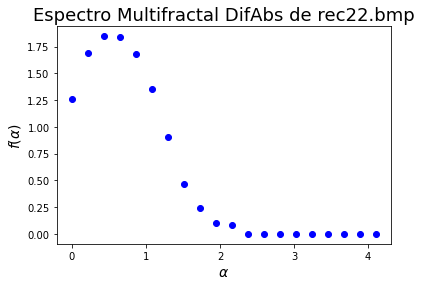

In [48]:
#espectro multifractal DifAbs rec22
AlfaImagen_dif_2=Alfa_Imagen_DifAbs(ArregloImagen_2,8)

VC_dif_2,PC_dif_2,C_dif_2=MaxMin(AlfaImagen_dif_2,20)

AlfaImagenCuant_dif_2=DAlfa(AlfaImagen_dif_2,PC_dif_2,VC_dif_2,C_dif_2)

falfa_dif_2=f_alfa(AlfaImagenCuant_dif_2,VC_dif_2,C_dif_2)

plt.plot(VC_dif_2,falfa_dif_2,'bo')
plt.ylabel(r'$f(\alpha)$',fontsize=14)
plt.xlabel(r'$ \alpha $',fontsize=14)
plt.title("Espectro Multifractal DifAbs de "+imagen_2,fontsize=18) 
plt.show() 

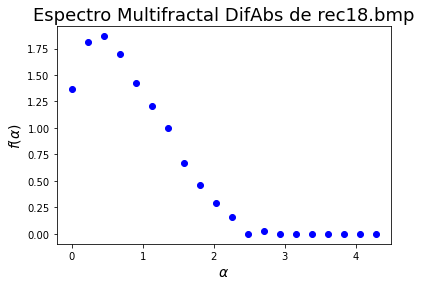

In [49]:
#espectro multifractal DifAbs rec18
AlfaImagen_dif_3=Alfa_Imagen_DifAbs(ArregloImagen_3,8)

VC_dif_3,PC_dif_3,C_dif_3=MaxMin(AlfaImagen_dif_3,20)

AlfaImagenCuant_dif_3=DAlfa(AlfaImagen_dif_3,PC_dif_3,VC_dif_3,C_dif_3)

falfa_dif_3=f_alfa(AlfaImagenCuant_dif_3,VC_dif_3,C_dif_3)

plt.plot(VC_dif_3,falfa_dif_3,'bo')
plt.ylabel(r'$f(\alpha)$',fontsize=14)
plt.xlabel(r'$ \alpha $',fontsize=14)
plt.title("Espectro Multifractal DifAbs de "+imagen_3,fontsize=18) 
plt.show() 